## Time series forecast study

Analyzing S&P 500 data from 1/4/2000 to 12/4/2024 (from "investing.com")

### Extracting and formatting relevant columns in the data

In [2]:
import pandas as pd

data = pd.read_csv('S&P 500 Historical Data.csv')

# Print a couple of rows
print("First few rows of the data:")
print(data.head())

# Print the shape of the data
print("\nShape of the data:")
print(data.shape)

data=data[['Date','Change %']]
data.rename(columns={'Change %': 'Return'}, inplace=True)
data['Return'] = data['Return'].str.replace('%', '').astype(float)
print(data.shape)
print(data.head())

First few rows of the data:
         Date     Price      Open      High       Low   Vol. Change %
0   12/4/2024  6,086.49  6,069.39  6,089.84  6,061.06  0.00K    0.61%
1   12/3/2024  6,049.88  6,042.97  6,052.07  6,033.39  0.00K    0.05%
2   12/2/2024  6,047.15  6,040.11  6,053.58  6,035.33  0.00K    0.24%
3  11/29/2024  6,032.38  6,003.98  6,044.17  6,003.98  0.00K    0.56%
4  11/27/2024  5,998.74  6,014.11  6,020.16  5,984.87  0.00K   -0.38%

Shape of the data:
(6270, 7)
(6270, 2)
         Date  Return
0   12/4/2024    0.61
1   12/3/2024    0.05
2   12/2/2024    0.24
3  11/29/2024    0.56
4  11/27/2024   -0.38


The first column is Date and it's starting from the most recent to the oldest. The last column is the return profit and calculated as:
$$R_t = \frac{(P_t - P_{t-1})}{P_{t}} \times 100$$
Where $P_t$ is the price at time $t$. We are interested in modeling the return. Let's just keep the Date and Change column.

### We use the ARIMA model to predict return ($Y_{t_0}$) at a future time based on returns ($Y_{t<t_0}$) in the past

## Introduction to the ARIMA Model

The ARIMA (AutoRegressive Integrated Moving Average) model is a popular time series forecasting method that combines three components:

- **AutoRegressive (AR)**: This component models the dependency of the current value on its previous values. It uses lagged values of the series to predict future values.
- **Integrated (I)**: The integration component involves differencing the series to make it stationary, meaning it removes trends and seasonality in the data.
- **Moving Average (MA)**: This component models the dependency of the current value on the residual errors from the past observations.

The ARIMA model is expressed as:

$$
Y_t = \mu + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \epsilon_t
$$

Where:
- $Y_t$ is the value of the time series at time $t$,
- $\mu$ is a constant,
- $ p $ is the number of autoregressive terms,
- $ \phi_i $ are the coefficients of the autoregressive model,
- $ q $ is the number of moving average terms,
- $ \theta_j $ are the coefficients of the moving average model,
- $ \epsilon_t $ is the white noise error term at time $t$.

The ARIMA model is typically denoted as **ARIMA(p, d, q)**, where:
- $ p $ is the order of the autoregressive component,
- $ d $ is the degree of differencing required to make the series stationary,
- $ q $ is the order of the moving average component.

The model is widely used in time series forecasting, particularly for non-seasonal data.


## Choosing the p (AR) Component

The **p** value in the ARIMA model refers to the number of lagged values used in the autoregressive (AR) part of the model. The **Partial Autocorrelation Function** (PACF) is used to determine the appropriate value of **p**.

### Equation for PACF:
The PACF at lag \(k\) is the partial correlation between $Y_t$ and $Y_{t-k}$ after removing the effects of all intervening lags. It is calculated as:

$$
\text{PACF}(k) = \text{corr}(Y_t, Y_{t-k} | Y_{t-1}, Y_{t-2}, \dots, Y_{t-(k-1)})
$$

Where:
- $Y_t$ is the value of the time series at time $t$,
- $Y_{t-k}$ is the value of the time series at lag $k$,
- The bar represents partial correlation, removing the effects of all intermediate lags.



## Choosing the q (MA) Component

The **q** value in the ARIMA model refers to the number of lagged forecast errors used in the moving average (MA) part of the model. The **Autocorrelation Function** (ACF) is used to determine the appropriate value of **q**.

### Equation for ACF:
The ACF at lag \(k\) is the autocorrelation between $Y_t$ and $Y_{t-k}$, defined as:

$$
\text{ACF}(k) = \frac{\sum_{t=k+1}^{T} (Y_t - \bar{Y})(Y_{t-k} - \bar{Y})}{\sum_{t=1}^{T} (Y_t - \bar{Y})^2}
$$

Where:
- $Y_t$ is the value of the time series at time $t$,
- $Y_{t-k}$ is the value of the time series at lag $k$,
- $\bar{Y}$ is the mean of the time series,
- $T$ is the total number of data points.



### How PACF Removes the Effects of Intervals

In the **Partial Autocorrelation Function (PACF)**, the effect of intervening lags is removed by adjusting for the correlations that exist between the intermediate lags. Essentially, the PACF measures the **direct correlation** between $Y_t$ and $Y_{t-k}$ after controlling for (or "removing") the influence of all other intermediate lags between $Y_t$ and $Y_{t-k}$.

This adjustment process is done through **regression**, and here’s how it works in more detail:

1. **Partial Correlation Definition**:
   The **partial correlation** between two time points (say, $Y_t$ and $Y_{t-k}$) is the correlation between those two points after removing the linear influence of all other time points in between.

2. **Recursive Regression**:
   To compute the PACF at a particular lag $k$, we use **multiple linear regression**:
   - We regress $Y_t$ on all of the previous time steps, from $Y_{t-1}$ to $Y_{t-(k-1)}$.
   - Then, we calculate the residuals from this regression, which represent the part of $Y_t$ that cannot be explained by the intervening time steps.
   - Next, we regress $Y_{t-k}$ on the same set of previous time steps.
   - Finally, the partial correlation at lag $k$ is the correlation between the residuals from these two regressions. This gives the **direct effect** between $Y_t$ and $Y_{t-k}$ after accounting for the influence of all the intermediate lags.

3. **The Role of Intervening Lags**:
   For example, when calculating the partial autocorrelation for lag $k = 3$, the PACF effectively looks at the correlation between $Y_t$ and $Y_{t-3}$ while controlling for the effect of $Y_{t-1}$ and $Y_{t-2}$. This means that the effect of $Y_{t-1}$ and $Y_{t-2}$ on both $Y_t$ and $Y_{t-3}$ is removed, so that only the **direct** correlation between $Y_t$ and $Y_{t-3}$ remains.

4. **Mathematical Formulation of Partial Correlation**:

   To formalize, the **partial correlation** between $Y_t$ and $Y_{t-k}$, denoted as $\text{PACF}(k)$, is given by the **regression coefficient** from the following model:
   
   $$
   Y_t = \alpha_1 Y_{t-1} + \alpha_2 Y_{t-2} + \dots + \alpha_{k-1} Y_{t-(k-1)} + \epsilon_t
   $$
   
   $$
   Y_{t-k} = \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \dots + \beta_{k-1} Y_{t-(k-1)} + \eta_t
   $$
   
   Where:
   - The $\alpha$'s and $\beta$'s are the regression coefficients,
   - $\epsilon_t$ and $\eta_t$ are the residuals from the regressions of $Y_t$ and $Y_{t-k}$ on the intervening lags.
   
   The **partial correlation** is then the correlation between the residuals $\epsilon_t$ and $\eta_t$, which represents the direct relationship between $Y_t$ and $Y_{t-k}$, free from the influence of the intermediate lags.

5. **Why This Is Important**:
   By removing the influence of the intermediate lags, the PACF allows us to:
   - Isolate the **direct** relationship between $Y_t$ and $Y_{t-k}$,
   - Accurately identify the **order** of the AR (autoregressive) process in ARIMA models, since we only want to know how each lag directly affects the current value, without the interference of other intermediate lags.

   This adjustment ensures that the PACF gives a **clearer picture** of the underlying autoregressive process, making it an effective tool for selecting the order **p** in the ARIMA model.


## The Integrated (I) Component of the ARIMA Model

The **Integrated** (I) component of the ARIMA model deals with making the time series **stationary**. A time series is said to be stationary if its statistical properties, such as mean, variance, and autocorrelation, do not change over time. Many time series models, including ARIMA, require the data to be stationary.

To achieve stationarity, we apply **differencing**, which involves subtracting the previous observation from the current observation. This is known as the **first difference**. If the series is still not stationary after the first differencing, we may apply **second differencing**, and so on.

### Differencing to Achieve Stationarity

Given a time series $Y_t$, the differenced series $\Delta Y_t$ is computed as:

$$
\Delta Y_t = Y_t - Y_{t-1}
$$

This is the first difference. If the series is still not stationary, we can apply the second difference:

$$
\Delta^2 Y_t = \Delta Y_t - \Delta Y_{t-1}
$$

This process is repeated until we obtain a stationary series. The number of differences required to make the series stationary is denoted by **d**, where **d** is the order of differencing.

### Example of Making a Series Stationary

Let's consider a simple example with a non-stationary time series:

Suppose we have the following time series of data:

$$
Y_t = [5, 7, 9, 11, 13, 15]
$$

This series clearly has a trend (it increases by 2 at each step), so it's not stationary. To make it stationary, we apply first differencing:

$$
\Delta Y_t = [7-5, 9-7, 11-9, 13-11, 15-13]
$$

This gives:

$$
\Delta Y_t = [2, 2, 2, 2, 2]
$$

Now, the differenced series has a constant mean (the difference is always 2), but it doesn't fluctuate in a way that would indicate non-stationarity anymore. This series is now stationary. Since we applied **one differencing**, we would set \( d = 1 \) for this ARIMA model.

### Checking Stationarity

To check whether differencing has achieved stationarity, we can visually inspect the plot of the time series, look at statistical tests like the **Augmented Dickey-Fuller** (ADF) test, or examine the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots.

In practice, we often start with \( d = 1 \) (first differencing) and check if the resulting series is stationary. If not, we increase \( d \) to 2, and so on.

### Summary

- The **Integrated** part of ARIMA is about making the series stationary using differencing.
- **d** is the order of differencing needed to achieve stationarity.
- We apply **first differencing** to subtract the previous value from the current one.
- The value of **d** can be determined through trial, using plots or statistical tests to check for stationarity.


### How to Fix the Parameters of an ARIMA Model

Once we have determined the appropriate values for the order of differencing $d$, and the autoregressive and moving average orders $p$ and $q$, the next step is to estimate the parameters of the ARIMA model. The ARIMA model has the following general form:

$$
(1 - \phi_1 L - \phi_2 L^2 - \dots - \phi_p L^p) (1 - L)^d Y_t = (1 + \theta_1 L + \theta_2 L^2 + \dots + \theta_q L^q) \epsilon_t
$$

Where:
- $Y_t$ is the time series,
- $L$ is the lag operator,
- $\phi_1, \phi_2, \dots, \phi_p$ are the autoregressive coefficients,
- $\theta_1, \theta_2, \dots, \theta_q$ are the moving average coefficients,
- $d$ is the order of differencing,
- $\epsilon_t$ is the error term (also called the white noise).

### Estimating the Parameters $\phi$ and $\theta$

After selecting the appropriate values of $p$, $d$, and $q$, we estimate the parameters $\phi_i$ (autoregressive coefficients) and $\theta_i$ (moving average coefficients). This is done by minimizing the **sum of squared errors** between the observed values $Y_t$ and the predicted values generated by the model.

#### 1. **Autoregressive Coefficients ($\phi$)**:
The autoregressive part of the model reflects the dependency of $Y_t$ on its past values. The coefficients $\phi_1, \phi_2, \dots, \phi_p$ are estimated through the following process:

- Start by fitting the model using a method such as **Ordinary Least Squares (OLS)**, **Maximum Likelihood Estimation (MLE)**, or **Yule-Walker equations**.
- For small values of $p$, the Yule-Walker method solves for $\phi$ by solving the system of equations derived from the autocorrelation function (ACF) of the residuals.
- For larger values of $p$, numerical optimization methods like **MLE** are typically used to estimate $\phi_i$ that minimize the residuals.

#### 2. **Moving Average Coefficients ($\theta$)**:
The moving average part models the relationship between the current observation and the past errors. The coefficients $\theta_1, \theta_2, \dots, \theta_q$ are estimated similarly:

- We solve for $\theta_i$ through **numerical optimization**, often using methods like **MLE** to minimize the difference between the model's predicted values and the actual values.
- In practice, software libraries like `statsmodels` in Python use **maximum likelihood estimation (MLE)** for parameter estimation, which iteratively adjusts the parameters to maximize the likelihood of observing the given time series.

#### 3. **Error Term ($\epsilon_t$)**:
Once the parameters $\phi$ and $\theta$ are estimated, the model's residuals or errors $\epsilon_t$ are computed as:

$$
\epsilon_t = Y_t - \hat{Y}_t
$$

Where $\hat{Y}_t$ is the predicted value of $Y_t$ based on the fitted ARIMA model. These residuals are assumed to be white noise (i.e., normally distributed with mean 0 and constant variance), which is an assumption of the ARIMA model.


### Understanding the Estimation Process in ARIMA

In ARIMA models, the error terms $\epsilon_t$ are not known initially because they depend on the difference between the observed values and the predicted values. However, we can estimate the parameters iteratively by using the following approaches:

#### 1. Initial Model Estimation:
We begin by making an initial guess for the parameters $\phi$ (autoregressive coefficients) and $\theta$ (moving average coefficients). 

#### 2. Fitting the AR and MA Terms:
- The AR terms, $\phi_1, \phi_2, \dots, \phi_p$, depend on the past values of the time series.
- The MA terms, $\theta_1, \theta_2, \dots, \theta_q$, depend on the past errors.

Since we don't know the past errors ($\epsilon_t$) at the beginning, we use an **iterative process** to estimate them.

#### 3. Iterative Estimation of Errors:
Initially, we assume that the errors $\epsilon_t$ are equal to the difference between the observed values and the predicted values from the model, using the initial guess of the parameters:

$$
\epsilon_t^{(0)} = Y_t - (\hat{\phi}_1 Y_{t-1} + \hat{\phi}_2 Y_{t-2} + \dots + \hat{\phi}_p Y_{t-p}) - (\hat{\theta}_1 \epsilon_{t-1} + \hat{\theta}_2 \epsilon_{t-2} + \dots + \hat{\theta}_q \epsilon_{t-q})
$$

This provides an initial set of errors $\epsilon_t^{(0)}$ (where $^{(0)}$ indicates the initial iteration). 

#### 4. Refining the Model:
After the first iteration, we update the model parameters $\phi$ and $\theta$ by minimizing the sum of squared residuals (or another criterion like maximum likelihood). Once the parameters are updated, we recompute the errors using the updated model parameters:

$$
\epsilon_t^{(1)} = Y_t - (\hat{\phi}_1^{(1)} Y_{t-1} + \hat{\phi}_2^{(1)} Y_{t-2} + \dots) - (\hat{\theta}_1^{(1)} \epsilon_{t-1} + \hat{\theta}_2^{(1)} \epsilon_{t-2} + \dots)
$$

This process is repeated iteratively until the parameters converge to stable values.

#### 5. Maximum Likelihood Estimation (MLE):
In practice, **Maximum Likelihood Estimation (MLE)** is often used to estimate the parameters. MLE involves finding the values of $\phi$ and $\theta$ that maximize the likelihood function, which is based on the assumption that the errors $\epsilon_t$ follow a normal distribution with mean 0 and constant variance.

The likelihood function can be written as:

$$
L(\phi, \theta) = \prod_{t=1}^{T} P(\epsilon_t | \phi, \theta)
$$

Where $P(\epsilon_t | \phi, \theta)$ is the probability density function of the error terms, which depends on the model parameters. In the case of Gaussian errors, this would be the normal distribution's probability density function.

### Summary of the Steps for Estimation:

1. **Initial Parameter Estimation**: Make initial guesses for $\phi$ and $\theta$.
2. **Estimate Errors**: Use these initial guesses to estimate the error terms $\epsilon_t$.
3. **Minimize Errors**: Update $\phi$ and $\theta$ by minimizing the sum of squared residuals (or maximizing the likelihood).
4. **Refinement**: Recalculate the errors with the updated parameters and repeat the process.
5. **Convergence**: Continue iterating until the parameters converge.

### Conclusion:
The key difference from linear regression is that in ARIMA models, we initially don't know the residuals. However, through iterative methods like MLE or least squares, we can estimate the parameters and errors simultaneously. The errors are updated in each iteration as the model parameters are refined, allowing us to estimate $\phi$ and $\theta$ effectively even though the errors are not known upfront.


### Evaluating the ARIMA Model

Once you have fit the ARIMA model, it's essential to assess its performance and check if it has adequately captured the patterns in the data. There are several ways to evaluate an ARIMA model:

#### 1. **Residual Analysis**:
   - **Residuals** are the differences between the observed values and the predicted values from the model. For a good model, the residuals should resemble white noise—this means they should be uncorrelated and have constant variance.
   
   - **Steps to check residuals**:
     1. **Plot the residuals**: If the residuals show no pattern (i.e., they appear randomly scattered around zero), the model is a good fit.
     2. **ACF and PACF of residuals**: Check if the residuals exhibit autocorrelation. The ACF and PACF plots should show no significant spikes, indicating that the model has captured the underlying temporal dependencies.
     3. **Histogram of residuals**: The residuals should approximately follow a normal distribution with mean 0 and constant variance.

   If the residuals show patterns, it indicates that the model has not captured all the dependencies in the data, and you may need to refine the model (adjust $p$, $q$, or $d$).

#### 2. **Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)**:
   Both AIC and BIC are used to compare models with different parameterizations. They penalize models with more parameters to avoid overfitting. Lower values of AIC or BIC indicate better models.

   - **Formula for AIC**:
     $$
     \text{AIC} = 2k - 2\log(L)
     $$
     where:
     - $k$ is the number of parameters in the model,
     - $L$ is the likelihood of the model.

   - **Formula for BIC**:
     $$
     \text{BIC} = \log(n)k - 2\log(L)
     $$
     where:
     - $n$ is the number of observations,
     - $k$ is the number of parameters,
     - $L$ is the likelihood of the model.

   The lower the AIC or BIC, the better the model fits the data, but you must balance this with model complexity.

#### 3. **Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)**:
   These metrics assess the average squared difference between the predicted and observed values, with lower values indicating a better fit.

   - **Formula for MSE**:
     $$
     \text{MSE} = \frac{1}{n} \sum_{t=1}^n (Y_t - \hat{Y}_t)^2
     $$

   - **Formula for RMSE**:
     $$
     \text{RMSE} = \sqrt{\frac{1}{n} \sum_{t=1}^n (Y_t - \hat{Y}_t)^2}
     $$

   Where $Y_t$ is the actual value, $\hat{Y}_t$ is the predicted value, and $n$ is the number of observations.

#### 4. **Out-of-Sample Forecasting**:
   One of the most important tests for an ARIMA model is its ability to forecast future data points. This is done by evaluating the model's performance on out-of-sample data (i.e., data that was not used in training the model).

   - **Steps to evaluate forecast accuracy**:
     1. **Split the data**: Divide your data into a training set (used for fitting the model) and a test set (used for evaluating the model's forecasts).
     2. **Generate forecasts**: Use the model to generate forecasts on the test set.
     3. **Compare forecasts to actual values**: Evaluate the accuracy of the forecasts using the metrics like RMSE, MSE, or even Mean Absolute Error (MAE).

   This is often considered the most reliable evaluation method, as it tests how well the model can predict new, unseen data.

#### 5. **Theil’s U-statistic**:
   The Theil's U-statistic compares the performance of the forecast to a naïve forecasting model (for example, using the previous value as the forecast). A smaller U-statistic indicates better forecasting performance.

   - **Formula for Theil’s U-statistic**:
     $$
     U = \frac{\sqrt{\frac{1}{n} \sum_{t=1}^n (Y_t - \hat{Y}_t)^2}}{\sqrt{\frac{1}{n} \sum_{t=1}^n (Y_t - Y_{t-1})^2}}
     $$

   Where $Y_t$ is the actual value and $\hat{Y}_t$ is the forecasted value.

### Conclusion:
- **Residual Analysis**: Check for randomness and no autocorrelation in residuals.
- **AIC/BIC**: Use these to compare different models and penalize overly complex models.
- **MSE/RMSE**: Measures the prediction error.
- **Out-of-Sample Forecasting**: Test how well the model can predict unseen data.
- **Theil’s U-statistic**: Compares the model's forecasting ability to a naïve model.

By using a combination of these metrics and methods, you can ensure that your ARIMA model is well-calibrated and provides accurate forecasts.


### How to Split Time Series Data for Forecasting

In time series forecasting, the most important consideration when splitting the data is maintaining the chronological order, since future values cannot be used to predict past ones. Here are the common ways to split time series data:

#### 1. **Train-Test Split (Hold-Out Method)**:
   The simplest method for splitting time series data is to use a hold-out approach, where you divide the data into a **training set** and a **test set**.

   - **Training Set**: This subset of the data is used to **fit** the ARIMA model (i.e., estimate the parameters).
   - **Test Set**: This subset of the data is used to **evaluate** the model's forecasting ability (i.e., compare the predicted values to the actual observed values).

   **Procedure**:
   - Let the time series be denoted as $Y_1, Y_2, Y_3, \dots, Y_T$ where $T$ is the total number of time points.
   - Split the data into a **training set** with the first $n$ time points, i.e., $(Y_1, Y_2, \dots, Y_n)$, and a **test set** with the remaining time points, i.e., $(Y_{n+1}, Y_{n+2}, \dots, Y_T)$.

   For example, if you have 1000 time points:
   - Training set: $Y_1, Y_2, \dots, Y_{800}$ (first 80% of the data).
   - Test set: $Y_{801}, Y_{802}, \dots, Y_{1000}$ (remaining 20% of the data).

   The **test set** should represent the most recent time points so you can evaluate the model’s forecasting accuracy on unseen data.

#### 2. **Rolling or Expanding Window**:
   In a time series context, especially when evaluating forecasting models, using a **rolling window** or **expanding window** approach is common. These methods allow you to evaluate the model's performance at various points in time.

   - **Rolling Window**: In this method, the training set remains the same size, and the window "rolls" forward as time progresses. For example, if you start with a training set of 800 observations, after testing on the next 100 observations, the training set will move forward by 100 observations, and the model is retrained with the new training set.
     
     - **Example**: For data points $Y_1, Y_2, \dots, Y_{1000}$:
       - Train on $Y_1, Y_2, \dots, Y_{800}$, test on $Y_{801}, Y_{802}, \dots, Y_{900}$.
       - Then, train on $Y_{101}, Y_{102}, \dots, Y_{900}$, test on $Y_{901}, Y_{902}, \dots, Y_{1000}$.
     
     This helps evaluate the model on various segments of the data and can be used to get a more robust estimate of forecasting performance.

   - **Expanding Window**: In this approach, the training set increases over time as the model is retrained. Starting with a small initial training set, you gradually increase the number of observations used for training.
     
     - **Example**: For data points $Y_1, Y_2, \dots, Y_{1000}$:
       - Train on $Y_1, Y_2, \dots, Y_{800}$, test on $Y_{801}, Y_{802}, \dots, Y_{1000}$.
       - Next, train on $Y_1, Y_2, \dots, Y_{900}$, test on the next 100 points, and so on.

   The expanding window provides more data for the model to learn from as time progresses, which is useful for capturing long-term trends in the data.

#### 3. **Leave-P-Out Cross Validation**:
   This is a more advanced technique where the data is split such that you leave out "p" observations each time for testing and train the model on the remaining data. This can be repeated for all possible splits, but for time series, it is less common and may be computationally expensive.

   **Procedure**:
   - For each iteration, leave out the most recent $p$ observations and use the previous data points for training. This allows you to test how well the model performs as time progresses.
   
#### Key Points to Remember:
   - **Temporal Order**: Always maintain the time order. Never shuffle the data.
   - **No Lookahead Bias**: Ensure that data from the future is never used to predict the past.
   - **Out-of-Sample Forecasting**: Always test on out-of-sample data (data not seen during training).
   - **Adjust Test Set Size**: The size of the test set should reflect the forecast horizon you are interested in. If you are forecasting for the next 30 days, the test set should contain at least 30 future data points.

#### Conclusion:
For time series forecasting, splitting the data correctly is crucial. The most common method is the **train-test split**, where you split the data chronologically into training and test sets. Alternatively, the **rolling window** or **expanding window** techniques can be used to evaluate the model's forecasting ability at various points in time.


### Chekcing ACF, PACF and stationary nature of data
To determine optimal $p$ (number of Autoregression terms), $q$ (number of lagged forecast errors), $d$ (number of nonseasonal differences)

ADF Statistic: -14.979404498284246
p-value: 1.1681506382348811e-27
The series is likely stationary (reject null hypothesis).
ACF Values:  [ 1.         -0.10156514 -0.01081757  0.00839364 -0.02604042 -0.01534658
 -0.03775008  0.02963465 -0.03013045  0.04072771 -0.00642743 -0.0100086
  0.03561468 -0.01137908 -0.00527816 -0.06185045  0.06577152 -0.00773464
 -0.03006222 -0.00210597  0.00660577 -0.01478689 -0.01001192  0.00379806
 -0.00778379 -0.00771857 -0.01428526  0.03062821 -0.00549332  0.01138999
  0.00386838 -0.01216825  0.00300969 -0.01340301 -0.04795399  0.013514
  0.02703973 -0.01285274 -0.00296893  0.02133648  0.00110175 -0.00807464
 -0.00208042 -0.03641895  0.001472    0.01057238 -0.02053088  0.02390028
 -0.00551588 -0.01909155 -0.01887166]
PACF Values:  [ 1.00000000e+00 -1.01581337e-01 -2.13602055e-02  5.16074827e-03
 -2.51594473e-02 -2.06406204e-02 -4.28563415e-02  2.13188693e-02
 -2.70541717e-02  3.56719310e-02 -2.41124193e-03 -9.60986080e-03
  3.15441745e-02 -1.96898027e-03 -

/Users/saptarshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


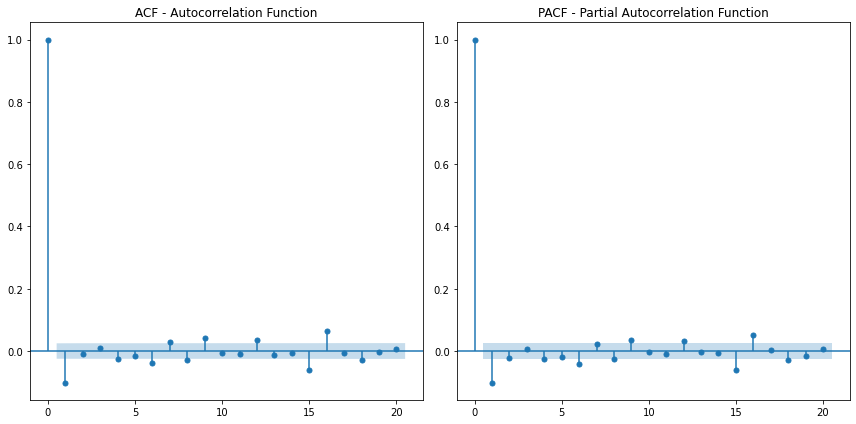

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# Assuming your data is in a DataFrame df with 'Date' and 'Return' columns
# df = pd.read_csv('your_data.csv', parse_dates=['Date'], index_col='Date']

# Checking Stationarity (ADF test)
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is likely stationary (reject null hypothesis).")
    else:
        print("The series is likely non-stationary (fail to reject null hypothesis).")

# Assuming 'Return' is the first differenced data
check_stationarity(data['Return'])

# Plot ACF and PACF with printing the numerical values
def plot_acf_pacf(series):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot ACF
    acf_values, confint_acf = acf(series, nlags=50, alpha=0.05)
    plot_acf(series, lags=20, ax=ax[0])
    ax[0].set_title('ACF - Autocorrelation Function')
    
    # Plot PACF
    pacf_values, confint_pacf = pacf(series, nlags=50, alpha=0.05)
    plot_pacf(series, lags=20, ax=ax[1])
    ax[1].set_title('PACF - Partial Autocorrelation Function')

    # Print the numerical list for ACF and PACF
    print("ACF Values: ", acf_values)
    print("PACF Values: ", pacf_values)

    plt.tight_layout()
    plt.show()

# Plot ACF and PACF for the Return data
plot_acf_pacf(data['Return'])


### Conclusion
 We take $p=q=2,d=0$

## Fitting the ARIMA model

We train it on the first (old) $70$% data and test on the last (recent) $30$% data

                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 4389
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7227.898
Date:                Fri, 06 Dec 2024   AIC                          14467.797
Time:                        00:20:39   BIC                          14506.118
Sample:                             0   HQIC                         14481.317
                               - 4389                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0399      0.017      2.336      0.019       0.006       0.073
ar.L1         -1.1148      0.045    -24.719      0.000      -1.203      -1.026
ar.L2         -0.2984      0.044     -6.753      0.0

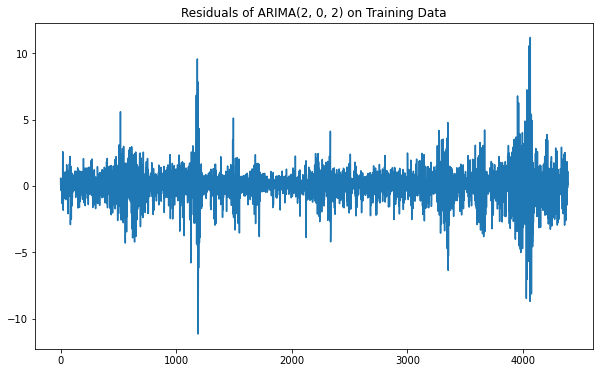

Forecast for test data: 4389    0.053211
4390    0.069652
4391    0.002678
4392    0.072433
4393    0.014660
          ...   
6265    0.039866
6266    0.039866
6267    0.039866
6268    0.039866
6269    0.039866
Name: predicted_mean, Length: 1881, dtype: float64
RMSE on all test data: 1.1086346177628523
RMSE of near future forecast: 0.6555352434863477


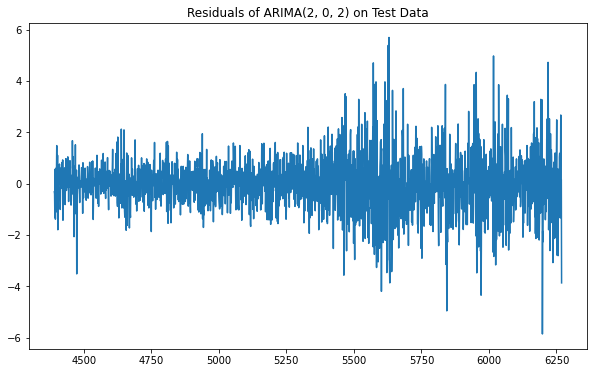

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming 'data' DataFrame is already loaded with 'Return' column
train_size = int(len(data) * 0.7)  # 70% for training
train_data = data[:train_size]
test_data = data[train_size:]

# Step 1: Fit ARIMA(2, 0, 2) model on the training data
model = ARIMA(train_data['Return'], order=(2,0,2))
fitted_model = model.fit()

# Print the model summary to see the details
print(fitted_model.summary())

# Step 2: Calculate RMSE on the training data
in_sample_pred = fitted_model.fittedvalues

# Exclude the first two points due to differencing
rmse = np.sqrt(mean_squared_error(train_data['Return'][2:], in_sample_pred[2:]))
print(f"RMSE on training data: {rmse}")

# Step 3: Get AIC and BIC for the model
# aic = fitted_model.aic
# bic = fitted_model.bic
# print(f"AIC: {aic}")
# print(f"BIC: {bic}")

# Step 4: (Optional) Check residuals on the training data (diagnostic)
residuals = fitted_model.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA(2, 0, 2) on Training Data')
plt.show()

# Step 5: Forecast on the test data (out-of-sample forecast)
forecast = fitted_model.forecast(steps=len(test_data))
print("Forecast for test data:", forecast)

# Step 6: Calculate RMSE on the test data
rmse_test = np.sqrt(mean_squared_error(test_data['Return'][2:], forecast[2:]))  # Exclude the first two points
print(f"RMSE on all test data: {rmse_test}")

rmse_test1 = np.sqrt(mean_squared_error(test_data['Return'][2:600], forecast[2:600]))  # Exclude the first two points
print(f"RMSE of near future forecast: {rmse_test1}")


plt.figure(figsize=(10, 6))
plt.plot(test_data['Return'][2:]-forecast[2:])
plt.title('Residuals of ARIMA(2, 0, 2) on Test Data')
plt.show()

#### Observation

The ARIMA model makes decent forecast for near future, but performs badly predicting long time outcome.

#### Variation in the mean and standard deviation of the residuals over time windows rolling from past to present

The error bars represent standard deviation during the corresponding time frame


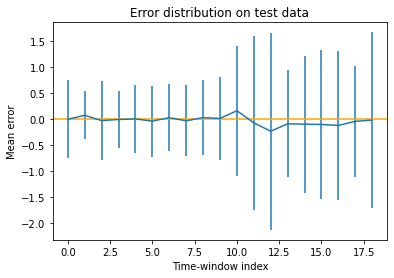

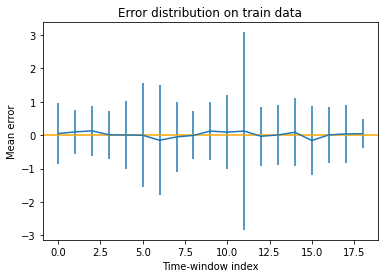

In [5]:
test_residues=test_data['Return'][2:]-forecast[2:]
err_mean=[np.mean(test_residues[100*i:100*(i+1)]) for i in range(19)]
err_std=[np.std(test_residues[100*i:100*(i+1)]) for i in range(19)]

print('The error bars represent standard deviation during the corresponding time frame')

fig, ax = plt.subplots()
ax.errorbar(np.arange(len(err_mean)),err_mean, yerr=err_std)
ax.set_xlabel('Time-window index')
ax.set_ylabel('Mean error')
ax.axhline(y=0,color='orange')
ax.set_title("Error distribution on test data")
plt.show()

train_residues=residuals
err_mean=[np.mean(train_residues[100*i:100*(i+1)]) for i in range(19)]
err_std=[np.std(train_residues[100*i:100*(i+1)]) for i in range(19)]

fig, ax = plt.subplots()
ax.errorbar(np.arange(len(err_mean)),err_mean, yerr=err_std)
ax.set_xlabel('Time-window index')
ax.set_ylabel('Mean error')
ax.axhline(y=0,color='orange')
ax.set_title("Error distribution on train data")
plt.show()

### Conclusion:

The model performs well on test data as long as the residues satisfy white noise distribution with constant standard deviation and near zero mean, with varying time. Deviations starts appearing after long time when new patterns unfitted in the model emerge to degrade its performance.